In [9]:
import pandas as pd
import pandasql
from pandasql import sqldf
from datetime import date
import numpy as np

import matplotlib.pyplot as plt
import matplotlib_venn as venn
from matplotlib_venn import venn2

save_result = 1
cycle_yr = '2008'
# DON'T FORGET TO CHANGE CYCLE DATES IF CHANGING CYCLE_YR
startcyc = date(int(cycle_yr)-2,11,8) 
endcyc = date(int(cycle_yr),11,4) 

In [3]:
cycle_yr_abr = cycle_yr[2:4]
filepath_addit = "../raw data/oth"+ str(int(cycle_yr_abr)-2).zfill(2) + "/itoth" + str(int(cycle_yr)-2) + ".txt"
filepath_main = "../raw data/oth"+ cycle_yr_abr + "/itoth" + cycle_yr + ".txt"

In [4]:
colnm=['CMTE_ID','AMNDT_IND','RPT_TP','TRANSACTION_PGI','IMAGE_NUM','TRANSACTION_TP','ENTITY_TP','NAME','CITY','STATE',
       'ZIP_CODE','EMPLOYER','OCCUPATION','TRANSACTION_DT','TRANSACTION_AMT','OTHER_ID','TRAN_ID','FILE_NUM','MEMO_CD',
       'MEMO_TEXT','SUB_ID'
]
coltypes = {'CMTE_ID': str, 'AMNDT_IND':str, 'RPT_TP':str, 'TRANSACTION_PGI':str, 'IMAGE_NUM':str, 'TRANSACTION_TP':str, 
            'ENTITY_TP':str,'NAME':str, 'CITY':str, 'STATE':str, 'ZIP_CODE':str, 'EMPLOYER':str, 'OCCUPATION':str, 
            'TRANSACTION_DT':str, 'TRANSACTION_AMT':float, 'OTHER_ID':str, 'TRAN_ID':str, 'FILE_NUM':str, 'MEMO_CD':str, 
            'MEMO_TEXT':str, 'SUB_ID':str
           }
data_addit = pd.read_csv(filepath_addit, 
                    sep='|', header=None, names = colnm, dtype=coltypes)

In [5]:
print(data_addit.shape)
data_addit.head()

(423705, 21)


CMTE_ID AMNDT_IND RPT_TP TRANSACTION_PGI    IMAGE_NUM TRANSACTION_TP  \
0  C00080655         N     Q1               P  25020162400            24K   
1  C00080655         N     Q1               P  25020162399            24K   
2  C00080655         N     Q1               G  25020162399            24K   
3  C00080655         N     Q1               P  25020162399            24K   
4  C00080655         N     Q1               P  25020162400            24K   

  ENTITY_TP NAME CITY STATE  ... EMPLOYER OCCUPATION TRANSACTION_DT  \
0       NaN  NaN  NaN   NaN  ...      NaN        NaN       03102005   
1       NaN  NaN  NaN   NaN  ...      NaN        NaN       03312005   
2       NaN  NaN  NaN   NaN  ...      NaN        NaN       03312005   
3       NaN  NaN  NaN   NaN  ...      NaN        NaN       02222005   
4       NaN  NaN  NaN   NaN  ...      NaN        NaN       02222005   

  TRANSACTION_AMT   OTHER_ID TRAN_ID FILE_NUM MEMO_CD MEMO_TEXT  \
0          1000.0  C00027987     NaN      NaN     NaN       NaN   
1          1000.0  C00344051     NaN      NaN     NaN       NaN   
2          2000.0  C00344051     NaN      NaN     NaN       NaN   
3          2000.0  C00349506     NaN      NaN     NaN       NaN   
4          1100.0  C00344473     NaN      NaN     NaN       NaN   

                SUB_ID  
0  2042920051056615089  
1  2042920051056615086  
2  2042920051056615087  
3  2042920051056615088  
4  2042920051056615090  

[5 rows x 21 columns]

In [21]:
# Check if there are any negative values for image_num, there shouldn't be for 2008
# If the below returns true, then there is a problem because there a negative values for image_num
any(data_addit['IMAGE_NUM'].str[0]=='-')
# Okay note to self, can't convert the image_num to integers because there's letters in the image_num sometimes.

False

Okay now I'm going to filter it and save only the ones with transaction_pgi containing 2020 into their own dataframe.

In [60]:
explicitly_incycle_data_addit = data_addit[data_addit['TRANSACTION_PGI'].str.contains(cycle_yr, na=False)]
explicitly_incycle_data_addit

Empty DataFrame
Columns: [CMTE_ID, AMNDT_IND, RPT_TP, TRANSACTION_PGI, IMAGE_NUM, TRANSACTION_TP, ENTITY_TP, NAME, CITY, STATE, ZIP_CODE, EMPLOYER, OCCUPATION, TRANSACTION_DT, TRANSACTION_AMT, OTHER_ID, TRAN_ID, FILE_NUM, MEMO_CD, MEMO_TEXT, SUB_ID]
Index: []

[0 rows x 21 columns]

Using the election cycle dates, find any transaction that's not marked as in the election cycle but should be, and add those as well.
    I might have to do some extra research on how early before an election cycle starts, transactions can be made that count towards that.
* So, for the 2020 file, I will use the fact that the 2020 election cycle was [11-7-2018, 11-3-2020] and extract any transactions that (have a transaction_pgi containing 2020) OR (11-7-2018 <= transaction_dt <= 11-3-2020).
    * This is assuming that the dates in itoth2020 are actually from 2019 to 2020...I know from analyzing some of the other data that there are some weird records with like year 0 or year that's way later than it should be the data file.
    * Improvement Idea 1) a): Come back and investigate these weird dates, and decide what to do with them. For now, I'll just ignore them and not include them in my dataset.
    * Improvement Idea 1) b): Make sure that transactions for an election cycle can't take place before or after the election cycle dates...more of a boundary case
For now, I'll discard itoth2020.txt after I extract the 2020 election cycle. 
I can always redownload it from the FEC if I want to add in more records or do the 2020 election cycle, but rn it's taking up a lot of space on my computer.

In [61]:
data_addit[['TRANSACTION_DT']] = pd.to_datetime(data_addit['TRANSACTION_DT'], format='%m%d%Y').dt.date
data_addit[['TRANSACTION_DT']]

TRANSACTION_DT
0          2005-03-10
1          2005-03-31
2          2005-03-31
3          2005-02-22
4          2005-02-22
...               ...
423700     2006-10-26
423701     2006-10-30
423702     2006-11-05
423703     2020-11-03
423704     2006-10-18

[423705 rows x 1 columns]

Improvement Idea 1) d): Visualize the distribution of dates by histogramming it by years, then months for each year, then months, and days

## Don't forget to change the cycle dates!!!

In [62]:
#greater than the start date and smaller than the end date
mask = (data_addit['TRANSACTION_DT'] >= startcyc) & (data_addit['TRANSACTION_DT'] <= endcyc)
includeby_date_addit_data = data_addit.loc[mask]
includeby_date_addit_data

CMTE_ID AMNDT_IND RPT_TP TRANSACTION_PGI    IMAGE_NUM  \
130254  C00011338         A     YE             NaN  26038971057   
165312  C00419259         A    30G               G  27990118430   
165397  C00312017         N     YE               P  27930108012   
165399  C00320754         N     YE               P  27940115992   
165400  C00195628         N     YE               P  27930107993   
...           ...       ...    ...             ...          ...   
423351  C70000112         N     YE             NaN  27039372041   
423352  C70000112         N     YE             NaN  27039372041   
423354  C70000112         N     YE             NaN  27039372041   
423355  C70000112         N     YE             NaN  27039372041   
423356  C70000112         N     YE             NaN  27039372041   

       TRANSACTION_TP ENTITY_TP                               NAME  \
130254            24K       NaN       VICTORY 2006, MARIA CANTWELL   
165312            16C       CAN                 KISSLING, ALBERT D   
165397            24K       PTY  DEMOCRATIC CONGRESSIONAL CAMPAIGN   
165399            16C       CAN               CHRISTENSEN, DONNA M   
165400            24K       CCM        CIRO RODRIGUEZ FOR CONGRESS   
...               ...       ...                                ...   
423351            24N       NaN                                NaN   
423352            24F       NaN                                NaN   
423354            24N       NaN                                NaN   
423355            24N       NaN                                NaN   
423356            24F       NaN                                NaN   

               CITY STATE  ...               EMPLOYER OCCUPATION  \
130254      SEATTLE    WA  ...                    NaN        NaN   
165312   LAS CRUCES    NM  ...  KISSLING FOR CONGRESS        NaN   
165397   WASHINGTON    DC  ...                    NaN        NaN   
165399    ST. CROIX    VI  ...                    NaN        NaN   
165400  SAN ANTONIO    TX  ...                    NaN        NaN   
...             ...   ...  ...                    ...        ...   
423351          NaN   NaN  ...                    NaN        NaN   
423352          NaN   NaN  ...                    NaN        NaN   
423354          NaN   NaN  ...                    NaN        NaN   
423355          NaN   NaN  ...                    NaN        NaN   
423356          NaN   NaN  ...                    NaN        NaN   

       TRANSACTION_DT TRANSACTION_AMT   OTHER_ID       TRAN_ID FILE_NUM  \
130254     2006-12-06          1000.0  C00416206  022816580625   204521   
165312     2006-11-25          1000.0  H6NM02085      C3480012   289830   
165397     2006-12-19         25000.0  C00000935         D1873   274008   
165399     2006-12-01          4288.0  H4VI00054    SA13A.6958   273988   
165400     2006-12-04           500.0  C00326066        D12160   273992   
...               ...             ...        ...           ...      ...   
423351     2006-12-01         16176.0  H6NY24144           NaN      NaN   
423352     2006-12-01         98374.0  H2OH13033           NaN      NaN   
423354     2006-12-01         16176.0  H4NY19073           NaN      NaN   
423355     2006-12-01         16176.0  H8NY27077           NaN      NaN   
423356     2006-12-01          3481.0  H6OH18157           NaN      NaN   

       MEMO_CD MEMO_TEXT               SUB_ID  
130254     NaN       NaN  1070820110008570570  
165312     NaN       NaN  4053020071077580379  
165397     NaN       NaN  4013120071074830389  
165399     NaN       NaN  4013120071074812389  
165400     NaN       NaN  4013120071074830277  
...        ...       ...                  ...  
423351     NaN       NaN  1032620070000533194  
423352     NaN       NaN  1032620070000533195  
423354     NaN       NaN  1032620070000533196  
423355     NaN       NaN  1032620070000533197  
423356     NaN       NaN  1032620070000533198  

[10869 rows x 21 columns]

Improvement idea 2) Investigate the records that are within the 2020 election cycle transaction_dt, but are marked as P2018, which may be for the 2018 election cycle or it may be for the 2020 cycle, and the ones that are marked as G2018, which are probably not in the 2020 election cycle....for now I'll leave it as is but I should come back and fix this.

In [63]:
pd.merge(left=explicitly_incycle_data_addit, right=includeby_date_addit_data, left_on='SUB_ID', right_on='SUB_ID')

Empty DataFrame
Columns: [CMTE_ID_x, AMNDT_IND_x, RPT_TP_x, TRANSACTION_PGI_x, IMAGE_NUM_x, TRANSACTION_TP_x, ENTITY_TP_x, NAME_x, CITY_x, STATE_x, ZIP_CODE_x, EMPLOYER_x, OCCUPATION_x, TRANSACTION_DT_x, TRANSACTION_AMT_x, OTHER_ID_x, TRAN_ID_x, FILE_NUM_x, MEMO_CD_x, MEMO_TEXT_x, CMTE_ID_y, AMNDT_IND_y, RPT_TP_y, TRANSACTION_PGI_y, IMAGE_NUM_y, TRANSACTION_TP_y, ENTITY_TP_y, NAME_y, CITY_y, STATE_y, ZIP_CODE_y, EMPLOYER_y, OCCUPATION_y, TRANSACTION_DT_y, TRANSACTION_AMT_y, OTHER_ID_y, TRAN_ID_y, FILE_NUM_y, MEMO_CD_y, MEMO_TEXT_y, SUB_ID]
Index: []

[0 rows x 41 columns]

So there are 0 records that are in both.

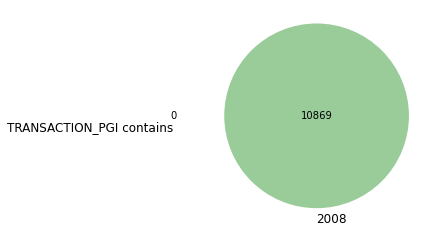

In [64]:
# Use the venn2 function
overlap = pd.merge(left=explicitly_incycle_data_addit, right=includeby_date_addit_data, left_on='SUB_ID', right_on='SUB_ID').shape[0]
# Find the number of rows of the ones that are explicitly included, and subtract from it the number that's in both
expincl_notin_dtrange = explicitly_incycle_data_addit.shape[0] - overlap
in_dtrange_not_expincl = includeby_date_addit_data.shape[0] - overlap
venn2(subsets = (expincl_notin_dtrange, in_dtrange_not_expincl , overlap), 
      set_labels = ('TRANSACTION_PGI contains', cycle_yr, 'TRANSACTION_DT in', cycle_yr, 'cycle date range'))
plt.show()

In [65]:
incycle_data_addit = pd.concat([explicitly_incycle_data_addit, includeby_date_addit_data])
# Drop duplicates from the concatenated dataset
incycle_data_addit.drop_duplicates(subset=['SUB_ID'], inplace=True)
incycle_data_addit

CMTE_ID AMNDT_IND RPT_TP TRANSACTION_PGI    IMAGE_NUM  \
130254  C00011338         A     YE             NaN  26038971057   
165312  C00419259         A    30G               G  27990118430   
165397  C00312017         N     YE               P  27930108012   
165399  C00320754         N     YE               P  27940115992   
165400  C00195628         N     YE               P  27930107993   
...           ...       ...    ...             ...          ...   
423351  C70000112         N     YE             NaN  27039372041   
423352  C70000112         N     YE             NaN  27039372041   
423354  C70000112         N     YE             NaN  27039372041   
423355  C70000112         N     YE             NaN  27039372041   
423356  C70000112         N     YE             NaN  27039372041   

       TRANSACTION_TP ENTITY_TP                               NAME  \
130254            24K       NaN       VICTORY 2006, MARIA CANTWELL   
165312            16C       CAN                 KISSLING, ALBERT D   
165397            24K       PTY  DEMOCRATIC CONGRESSIONAL CAMPAIGN   
165399            16C       CAN               CHRISTENSEN, DONNA M   
165400            24K       CCM        CIRO RODRIGUEZ FOR CONGRESS   
...               ...       ...                                ...   
423351            24N       NaN                                NaN   
423352            24F       NaN                                NaN   
423354            24N       NaN                                NaN   
423355            24N       NaN                                NaN   
423356            24F       NaN                                NaN   

               CITY STATE  ...               EMPLOYER OCCUPATION  \
130254      SEATTLE    WA  ...                    NaN        NaN   
165312   LAS CRUCES    NM  ...  KISSLING FOR CONGRESS        NaN   
165397   WASHINGTON    DC  ...                    NaN        NaN   
165399    ST. CROIX    VI  ...                    NaN        NaN   
165400  SAN ANTONIO    TX  ...                    NaN        NaN   
...             ...   ...  ...                    ...        ...   
423351          NaN   NaN  ...                    NaN        NaN   
423352          NaN   NaN  ...                    NaN        NaN   
423354          NaN   NaN  ...                    NaN        NaN   
423355          NaN   NaN  ...                    NaN        NaN   
423356          NaN   NaN  ...                    NaN        NaN   

       TRANSACTION_DT TRANSACTION_AMT   OTHER_ID       TRAN_ID FILE_NUM  \
130254     2006-12-06          1000.0  C00416206  022816580625   204521   
165312     2006-11-25          1000.0  H6NM02085      C3480012   289830   
165397     2006-12-19         25000.0  C00000935         D1873   274008   
165399     2006-12-01          4288.0  H4VI00054    SA13A.6958   273988   
165400     2006-12-04           500.0  C00326066        D12160   273992   
...               ...             ...        ...           ...      ...   
423351     2006-12-01         16176.0  H6NY24144           NaN      NaN   
423352     2006-12-01         98374.0  H2OH13033           NaN      NaN   
423354     2006-12-01         16176.0  H4NY19073           NaN      NaN   
423355     2006-12-01         16176.0  H8NY27077           NaN      NaN   
423356     2006-12-01          3481.0  H6OH18157           NaN      NaN   

       MEMO_CD MEMO_TEXT               SUB_ID  
130254     NaN       NaN  1070820110008570570  
165312     NaN       NaN  4053020071077580379  
165397     NaN       NaN  4013120071074830389  
165399     NaN       NaN  4013120071074812389  
165400     NaN       NaN  4013120071074830277  
...        ...       ...                  ...  
423351     NaN       NaN  1032620070000533194  
423352     NaN       NaN  1032620070000533195  
423354     NaN       NaN  1032620070000533196  
423355     NaN       NaN  1032620070000533197  
423356     NaN       NaN  1032620070000533198  

[10869 rows x 21 columns]

# 2008 Cycle Data from the 2007-2008 itoth data

In [66]:
data2008 = pd.read_csv(filepath_main, 
                    sep='|', header=None, names = colnm, dtype=coltypes)

In [67]:
print(data2008.shape)
data2008.head()

(693384, 21)


CMTE_ID AMNDT_IND RPT_TP TRANSACTION_PGI    IMAGE_NUM TRANSACTION_TP  \
0  C00371021         A     Q2               P  27990778802            16C   
1  C00343863         N     Q3               P  27990795865            24K   
2  C00116632         N     Q3               P  27931382236            24K   
3  C00116632         N     Q3               P  27931382236            24K   
4  C00116632         N     Q3               P  27931382236            24K   

  ENTITY_TP                               NAME        CITY STATE  ...  \
0       CAN                    BRADLEY, JOSEPH   WOLFEBORO    NH  ...   
1       ORG               MICHIGAN REPUBLICANS     LANSING    MI  ...   
2       COM  NATIONAL REPUBLICAN CONGRESSIONAL  WASHINGTON    DC  ...   
3       COM  NATIONAL REPUBLICAN CONGRESSIONAL  WASHINGTON    DC  ...   
4       COM       REPUBLICAN PARTY OF KENTUCKY   FRANKFORT    KY  ...   

    EMPLOYER OCCUPATION TRANSACTION_DT TRANSACTION_AMT   OTHER_ID  \
0  H2NH01130        NaN       06302007         10000.0  H2NH01130   
1        NaN        NaN       07232007         40000.0  C00041160   
2        NaN        NaN       08032007          2100.0  C00075820   
3        NaN        NaN       09052007         25000.0  C00075820   
4        NaN        NaN       07312007         25000.0  C00156810   

       TRAN_ID FILE_NUM MEMO_CD MEMO_TEXT               SUB_ID  
0  C-47-006M09   307028     NaN       NaN  4101520071081288342  
1    B-E-39500   307489     NaN       NaN  4101720071081637455  
2  D126-00521N   307500     NaN       NaN  4102220071081761789  
3  D127-00521O   307500     NaN       NaN  4102220071081761790  
4  D137-00B80F   307500     NaN       NaN  4102220071081761792  

[5 rows x 21 columns]

In [68]:
cy08fr08 = data2008[data2008['TRANSACTION_PGI'].str.contains(cycle_yr, na=False)]
cy08fr08.shape

(4954, 21)

In [69]:
## Find 1016-01-02
#data2014[data2014['TRANSACTION_DT'].str.contains("....1014", na=False)]

Ahh okay I see, so there are three rows that are supposedly from January 2nd, 1016 - which is clearly nonsensical. This was probably a typo where someone typed 1016 instead of 2016
Improvement idea 1) c) ii) I will validate the ground truth by finding the original filing.
For now, I will get rid of these rows, then convert it to a date.

In [70]:
#data2012 = data2012[~data2012['TRANSACTION_DT'].str.contains("....1016", na=False)]
#data2016.shape

In [71]:
data2008[['TRANSACTION_DT']] = pd.to_datetime(data2008['TRANSACTION_DT'], format='%m%d%Y').dt.date
data2008[['TRANSACTION_DT']]

TRANSACTION_DT
0          2007-06-30
1          2007-07-23
2          2007-08-03
3          2007-09-05
4          2007-07-31
...               ...
693379     2008-10-09
693380     2008-10-10
693381     2008-10-09
693382     2008-10-09
693383     2008-10-09

[693384 rows x 1 columns]

In [72]:
#greater than the start date and smaller than the end date
mask = (data2008['TRANSACTION_DT'] >= startcyc) & (data2008['TRANSACTION_DT'] <= endcyc)
dates_in_2008cyc_fr2008 = data2008.loc[mask]
dates_in_2008cyc_fr2008.shape

(663473, 21)

Hmm, how many of the 989,436 records I found contain 2020 in the transaction_pgi? What does the venn diagram look like with transaction_pgi containing 2020? How many are both? How many are just in the date range? How many just contain 2020 in transaction_pgi?

In [73]:
pd.merge(left=cy08fr08, right=dates_in_2008cyc_fr2008, left_on='SUB_ID', right_on='SUB_ID').shape

(4746, 41)

In [74]:
print('So there are 3238 records that are in both, and since there were 4954 records that contained ', cycle_yr,  
      'in its transaction_pgi, that means that there are 4954-3238 = 1716 records that weren\'t in the date range \
      but did contain', cycle_yr ,'in the transaction_pgi \n. Since there were 652459 rows that were in the date range, \
      there were 652459-3238= 649221 records that were in the', cycle_yr ,'cycle date range but didn\'t have \
      transaction_pgi containing', cycle_yr ,'.\n There should be 4954+652459-3238 = 654175 rows in the dataframe \
      consisting of', cycle_yr ,'cycle transactions.')

So there are 3238 records that are in both, and since there were 4954 records that contained  2008 in its transaction_pgi, that means that there are 4954-3238 = 1716 records that weren't in the date range       but did contain 2008 in the transaction_pgi 
. Since there were 652459 rows that were in the date range,       there were 652459-3238= 649221 records that were in the 2008 cycle date range but didn't have       transaction_pgi containing 2008 .
 There should be 4954+652459-3238 = 654175 rows in the dataframe       consisting of 2008 cycle transactions.


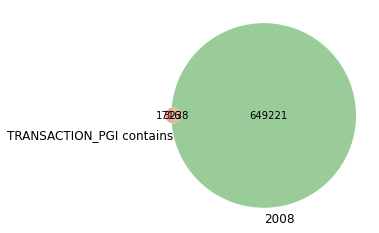

In [75]:
# Use the venn2 function
venn2(subsets = (1716 , 649221  , 3238 ), set_labels = ('TRANSACTION_PGI contains', cycle_yr, 'TRANSACTION_DT in', cycle_yr ,'cycle date range'))
plt.show()
# I wonder what is the transaction_dt range and distribution for records where transaction_pgi contains 2020, and how far off it is from the 2020 election cycle.
    # Improvement idea 2) b) Investigate this to see if it can help me get the correct dates.

In [76]:
cy08fr08v2 = pd.concat([cy08fr08, dates_in_2008cyc_fr2008])
# Drop duplicates from the concatenated dataset
cy08fr08v2.drop_duplicates(subset=['SUB_ID'], inplace=True)

In [77]:
# First, vertically concatenate the two dataframes
# then save the result to a csv
# check the number of rows in cy18fr16 and cy18fr18
print('Shape for', cycle_yr ,'election cycle transactions from', str(int(cycle_yr)-2), ': ', str(incycle_data_addit.shape))
print('Shape for', cycle_yr ,'election cycle transactions from', cycle_yr,': ', str(cy08fr08v2.shape))
print('There should be', incycle_data_addit.shape[0]+cy08fr08v2.shape[0], 'rows total for', cycle_yr, 'election cycle transactions.' )

Shape for 2008 election cycle transactions from 2006 :  (10869, 21)
Shape for 2008 election cycle transactions from 2008 :  (663681, 21)
There should be 674550 rows total for 2008 election cycle transactions.


In [78]:
fec_cy2008 = pd.concat([incycle_data_addit, cy08fr08v2], ignore_index=True)
fec_cy2008

CMTE_ID AMNDT_IND RPT_TP TRANSACTION_PGI    IMAGE_NUM  \
0       C00011338         A     YE             NaN  26038971057   
1       C00419259         A    30G               G  27990118430   
2       C00312017         N     YE               P  27930108012   
3       C00320754         N     YE               P  27940115992   
4       C00195628         N     YE               P  27930107993   
...           ...       ...    ...             ...          ...   
674545  C00003418         A    12G             NaN  29992376993   
674546  C00003418         A    12G             NaN  29992376996   
674547  C00003418         A    12G             NaN  29992376997   
674548  C00003418         A    12G             NaN  29992380751   
674549  C00003418         A    12G             NaN  29992380753   

       TRANSACTION_TP ENTITY_TP                               NAME  \
0                 24K       NaN       VICTORY 2006, MARIA CANTWELL   
1                 16C       CAN                 KISSLING, ALBERT D   
2                 24K       PTY  DEMOCRATIC CONGRESSIONAL CAMPAIGN   
3                 16C       CAN               CHRISTENSEN, DONNA M   
4                 24K       CCM        CIRO RODRIGUEZ FOR CONGRESS   
...               ...       ...                                ...   
674545            15J       IND              MACALUSO, MICHAEL MR.   
674546            15J       IND               MACAULY, HUGH H. MR.   
674547            15J       IND                   MACCHIA, RICHARD   
674548            15J       IND                        MUSKET, F R   
674549            15J       IND                   MUSSEHL, STEPHAN   

               CITY STATE  ...                        EMPLOYER  \
0           SEATTLE    WA  ...                             NaN   
1        LAS CRUCES    NM  ...           KISSLING FOR CONGRESS   
2        WASHINGTON    DC  ...                             NaN   
3         ST. CROIX    VI  ...                             NaN   
4       SAN ANTONIO    TX  ...                             NaN   
...             ...   ...  ...                             ...   
674545  MINNEAPOLIS    MN  ...          FAEGRE & BENSON L.L.P.   
674546      CONIFER    CO  ...                             NaN   
674547     NEW YORK    NY  ...  UNIVERSITY PHYSIIANS OF BROOKL   
674548     FT MYERS    FL  ...                         RETIRED   
674549       SPARKS    NV  ...         BROWN CAMERON CALVANESE   

               OCCUPATION TRANSACTION_DT TRANSACTION_AMT   OTHER_ID  \
0                     NaN     2006-12-06          1000.0  C00416206   
1                     NaN     2006-11-25          1000.0  H6NM02085   
2                     NaN     2006-12-19         25000.0  C00000935   
3                     NaN     2006-12-01          4288.0  H4VI00054   
4                     NaN     2006-12-04           500.0  C00326066   
...                   ...            ...             ...        ...   
674545   PARTNER-LAW FIRM     2008-10-09          1000.0        NaN   
674546          REQUESTED     2008-10-10           200.0        NaN   
674547          PHYSICIAN     2008-10-09           200.0        NaN   
674548  CHEMICAL ENGINEER     2008-10-09          1000.0        NaN   
674549          PHYSICIAN     2008-10-09          1000.0        NaN   

             TRAN_ID FILE_NUM MEMO_CD  \
0       022816580625   204521     NaN   
1           C3480012   289830     NaN   
2              D1873   274008     NaN   
3         SA13A.6958   273988     NaN   
4             D12160   273992     NaN   
...              ...      ...     ...   
674545      50576504   421937       X   
674546      50733617   421937       X   
674547      50591911   421937       X   
674548      50566745   421937       X   
674549      50621026   421937       X   

                                                MEMO_TEXT               SUB_ID  
0                                                     NaN  1070820110008570570  
1                                                     NaN  4053

Now that I have the itoth data from the 2016 election cycle, I'm going to extract it to the relevant records, which is those with (transaction_tp = '24Z') and (entity_tp<>'IND' or entity_tp is null). <br>
Then, I will extract the first digits of the transaction amounts into their own column.

In [79]:
fec_cy2008_ctc = fec_cy2008[(fec_cy2008["TRANSACTION_TP"]=='24Z') & ((fec_cy2008["ENTITY_TP"]!='IND') | (fec_cy2008["ENTITY_TP"].isnull()))] 

In [80]:
# Extract the first digits of transaction_amt
fec_cy2008_ctc = fec_cy2008_ctc.assign(amt_firstdig=fec_cy2008_ctc['TRANSACTION_AMT'].astype(str).str[:1].values)
fec_cy2008_ctc[['TRANSACTION_AMT', 'amt_firstdig']]

TRANSACTION_AMT amt_firstdig
209              1000.0            1
219              2000.0            2
668                57.0            5
669               118.0            1
925               722.0            7
...                 ...          ...
663702            999.0            9
663706             24.0            2
663710            876.0            8
663711            195.0            1
663712           3396.0            3

[8173 rows x 2 columns]

In [81]:
# drop those where transaction_amt not in [1,9], eg. if it's 0 or negative
firstdigitslist = ['1', '2', '3', '4', '5', '6', '7', '8', '9']
fec_cy2008_ctc = fec_cy2008_ctc[fec_cy2008_ctc['amt_firstdig'].isin(firstdigitslist)]

In [82]:
if save_result == 1:
    fec_cy2008_ctc.to_csv('FEC-itoth-'+ cycle_yr +'cycle-ctc-inkind.csv', sep = '|', index = False)